# 1.0 Importamos las librerías a utilizar

In [5]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import joblib
import os
import pickle
from numpy.random import seed, choice
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 2.0 Cargar los datos divididos desde el análisis previo

In [7]:
# Cargar el dataframe limpio del análisis previo
df = pd.read_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')

print("✅ Dataframe cargado exitosamente")
print(f"📊 Forma del dataframe: {df.shape}")
df.head()

✅ Dataframe cargado exitosamente
📊 Forma del dataframe: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# 2.1 Dividir los datos en entrenamiento y prueba

In [8]:
# Separar características y variable objetivo
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.2 Imputación de valores faltantes (DESPUÉS del split)

In [9]:
# Crear el imputador iterativo
imputer = IterativeImputer(random_state=42, max_iter=10, verbose=0)

print("Valores faltantes ANTES de la imputación:")
print(f"X_train: {X_train.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test.isna().sum().sum()} valores faltantes")

# PASO 1: Entrenar el imputador SOLO con los datos de entrenamiento
imputer.fit(X_train)

# PASO 2: Transformar ambos conjuntos usando el imputador entrenado
X_train_imputed = pd.DataFrame(
    imputer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\n" + "="*60)
print("Valores faltantes DESPUÉS de la imputación:")
print(f"X_train: {X_train_imputed.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test_imputed.isna().sum().sum()} valores faltantes")

# Verificar valores negativos y corregirlos si existen
for col in X_train_imputed.columns:
    if (X_train_imputed[col] < 0).any():
        print(f"⚠️  Corrigiendo valores negativos en {col}")
        median_val = X_train_imputed[X_train_imputed[col] >= 0][col].median()
        X_train_imputed.loc[X_train_imputed[col] < 0, col] = median_val
        X_test_imputed.loc[X_test_imputed[col] < 0, col] = median_val

print("\n✅ Imputación completada correctamente SIN data leakage")
print(f"📊 X_train shape: {X_train_imputed.shape}")
print(f"📊 X_test shape: {X_test_imputed.shape}")

# Actualizar los conjuntos de datos
X_train = X_train_imputed
X_test = X_test_imputed

Valores faltantes ANTES de la imputación:
X_train: 502 valores faltantes
X_test: 150 valores faltantes

Valores faltantes DESPUÉS de la imputación:
X_train: 0 valores faltantes
X_test: 0 valores faltantes
⚠️  Corrigiendo valores negativos en Insulin

✅ Imputación completada correctamente SIN data leakage
📊 X_train shape: (614, 8)
📊 X_test shape: (154, 8)


# 3.0 Entrenamiento de Random Forest

In [10]:
# Crear y entrenar un bosque simple
rf_simple = RandomForestClassifier(
    n_estimators=5, 
    max_depth=2, 
    min_samples_leaf=20, 
    max_features=X_train.shape[1]//2, 
    random_state=42,
    bootstrap=True  # Bootstrap está activado por defecto
)
rf_simple.fit(X_train, y_train)

# Bosque complejo
rf_complex = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20, 
    min_samples_leaf=1, 
    max_features=int(X_train.shape[1]*0.8), 
    random_state=42,
    bootstrap=True
)
rf_complex.fit(X_train, y_train)

print("✅ Modelos Random Forest entrenados exitosamente")

✅ Modelos Random Forest entrenados exitosamente


In [11]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = rf_complex.predict(X_train)
test_pred_complex = rf_complex.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = rf_simple.predict(X_train)
test_pred_simple = rf_simple.predict(X_test)

In [12]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [13]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.727273,0.631579,0.711111,0.610169,0.654545,0.767677
Diferencia,0.272727,0.368421,0.288889,0.389831,0.345455,0.232323


In [14]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.788274,0.661458,0.743259,0.742690,0.596244,0.890274
Test,0.766234,0.647059,0.729293,0.702128,0.600000,0.858586
Diferencia,0.022040,0.014400,0.013966,0.040562,-0.003756,0.031688


# 3.1 Análisis del impacto del número de árboles (n_estimators)

In [15]:
# Probar diferentes números de estimadores
n_estimators_values = [5, 10, 25, 50, 100, 150, 200]
results_n_estimators = []

for n_est in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    
    train_score = accuracy_score(y_train, rf.predict(X_train))
    test_score = accuracy_score(y_test, rf.predict(X_test))
    f1_test = f1_score(y_test, rf.predict(X_test))
    
    results_n_estimators.append({
        'n_estimators': n_est,
        'train_accuracy': train_score,
        'test_accuracy': test_score,
        'f1_score': f1_test,
        'overfitting': train_score - test_score
    })

df_n_estimators = pd.DataFrame(results_n_estimators)
print("Impacto del número de árboles (n_estimators):")
print(df_n_estimators)

Impacto del número de árboles (n_estimators):
   n_estimators  train_accuracy  test_accuracy  f1_score  overfitting
0             5        0.949511       0.733766  0.630631     0.215745
1            10        0.975570       0.766234  0.684211     0.209336
2            25        0.986971       0.779221  0.706897     0.207750
3            50        0.995114       0.772727  0.700855     0.222387
4           100        1.000000       0.733766  0.637168     0.266234
5           150        0.996743       0.733766  0.637168     0.262976
6           200        0.998371       0.720779  0.619469     0.277592


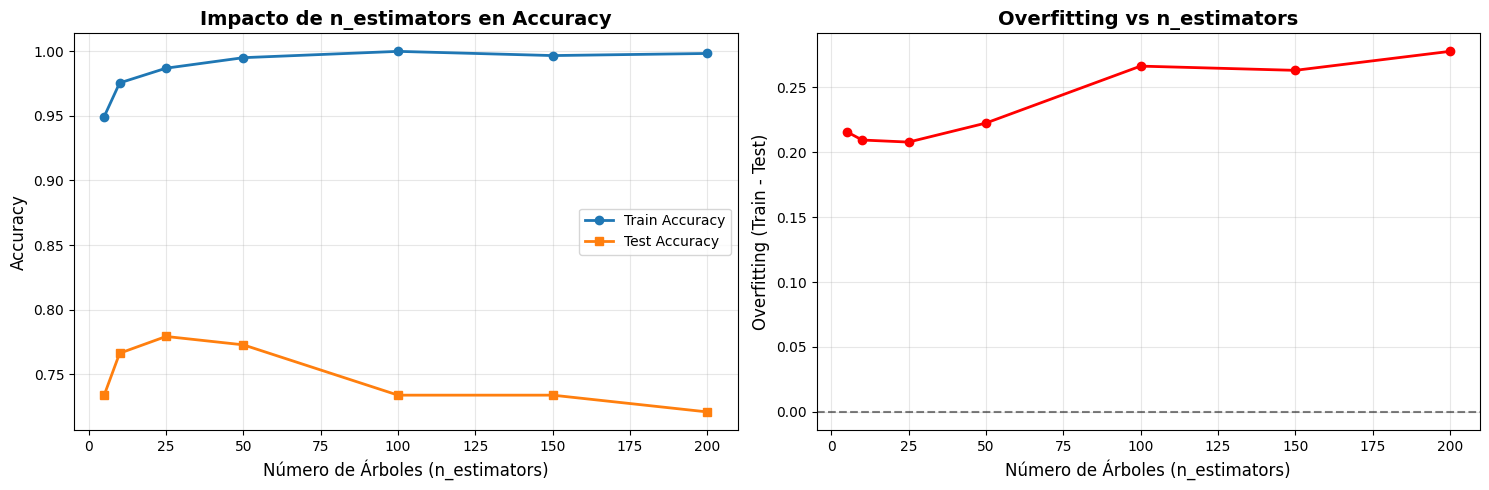

In [16]:
# Gráfica del impacto de n_estimators
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Accuracy vs n_estimators
axes[0].plot(df_n_estimators['n_estimators'], df_n_estimators['train_accuracy'], 
             marker='o', label='Train Accuracy', linewidth=2)
axes[0].plot(df_n_estimators['n_estimators'], df_n_estimators['test_accuracy'], 
             marker='s', label='Test Accuracy', linewidth=2)
axes[0].set_xlabel('Número de Árboles (n_estimators)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impacto de n_estimators en Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfica 2: Overfitting vs n_estimators
axes[1].plot(df_n_estimators['n_estimators'], df_n_estimators['overfitting'], 
             marker='o', color='red', linewidth=2)
axes[1].set_xlabel('Número de Árboles (n_estimators)', fontsize=12)
axes[1].set_ylabel('Overfitting (Train - Test)', fontsize=12)
axes[1].set_title('Overfitting vs n_estimators', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3.2 Análisis del impacto de la profundidad máxima (max_depth)

In [17]:
# Probar diferentes profundidades máximas
max_depth_values = [3, 5, 7, 10, 15, 20, None]
results_max_depth = []

for depth in max_depth_values:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    
    train_score = accuracy_score(y_train, rf.predict(X_train))
    test_score = accuracy_score(y_test, rf.predict(X_test))
    f1_test = f1_score(y_test, rf.predict(X_test))
    
    results_max_depth.append({
        'max_depth': str(depth),
        'train_accuracy': train_score,
        'test_accuracy': test_score,
        'f1_score': f1_test,
        'overfitting': train_score - test_score
    })

df_max_depth = pd.DataFrame(results_max_depth)
print("Impacto de la profundidad máxima (max_depth):")
print(df_max_depth)

Impacto de la profundidad máxima (max_depth):
  max_depth  train_accuracy  test_accuracy  f1_score  overfitting
0         3        0.794788       0.766234  0.647059     0.028555
1         5        0.863192       0.740260  0.629630     0.122932
2         7        0.936482       0.746753  0.654867     0.189729
3        10        1.000000       0.733766  0.637168     0.266234
4        15        1.000000       0.759740  0.666667     0.240260
5        20        1.000000       0.779221  0.690909     0.220779
6      None        1.000000       0.779221  0.690909     0.220779


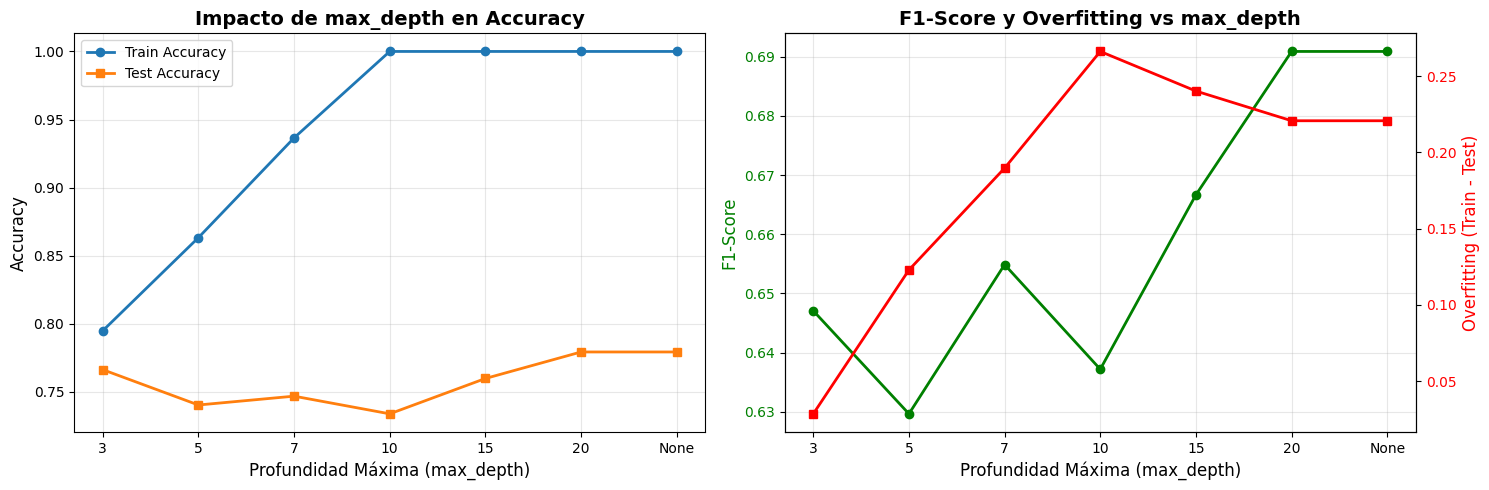

In [18]:
# Gráfica del impacto de max_depth
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Accuracy vs max_depth
x_labels = df_max_depth['max_depth']
x_pos = np.arange(len(x_labels))

axes[0].plot(x_pos, df_max_depth['train_accuracy'], marker='o', label='Train Accuracy', linewidth=2)
axes[0].plot(x_pos, df_max_depth['test_accuracy'], marker='s', label='Test Accuracy', linewidth=2)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].set_xlabel('Profundidad Máxima (max_depth)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impacto de max_depth en Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfica 2: F1-Score y Overfitting vs max_depth
ax2 = axes[1]
ax2.plot(x_pos, df_max_depth['f1_score'], marker='o', color='green', linewidth=2, label='F1-Score')
ax2.set_xlabel('Profundidad Máxima (max_depth)', fontsize=12)
ax2.set_ylabel('F1-Score', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels)

ax3 = ax2.twinx()
ax3.plot(x_pos, df_max_depth['overfitting'], marker='s', color='red', linewidth=2, label='Overfitting')
ax3.set_ylabel('Overfitting (Train - Test)', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

axes[1].set_title('F1-Score y Overfitting vs max_depth', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.0 Optimización con GridSearchCV

In [19]:
# Búsqueda de los mejores hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

print("Iniciando búsqueda de hiperparámetros óptimos...")
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("Mejores hiperparámetros encontrados:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1 Score en validación cruzada: {grid_search.best_score_:.4f}")

# Guardar el mejor modelo
best_rf_model = grid_search.best_estimator_

Iniciando búsqueda de hiperparámetros óptimos...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, 

In [20]:
# Evaluar el mejor modelo
y_pred_train_best = best_rf_model.predict(X_train)
y_pred_test_best = best_rf_model.predict(X_test)

best_metrics = get_metrics(y_train, y_test, y_pred_train_best, y_pred_test_best)

print("\n" + "="*60)
print("Métricas del Random Forest optimizado:")
print("="*60)
print(best_metrics)


Métricas del Random Forest optimizado:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.978827  0.969121  0.973886   0.980769  0.957746     0.990025
Test        0.746753  0.654867  0.730303   0.637931  0.672727     0.787879
Diferencia  0.232074  0.314254  0.243583   0.342838  0.285019     0.202146


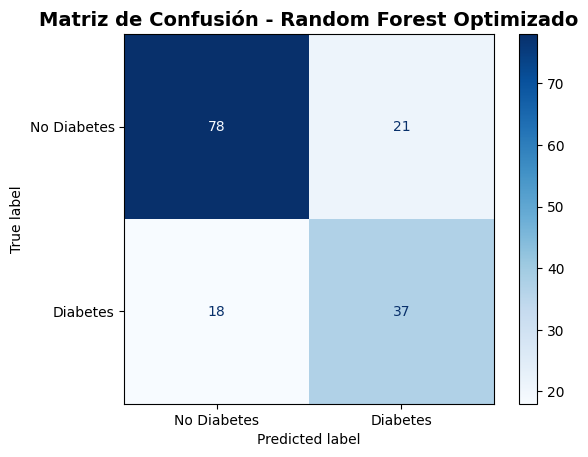

In [21]:
# Matriz de confusión del modelo optimizado
cm_best = confusion_matrix(y_test, y_pred_test_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Diabetes', 'Diabetes'])
disp_best.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Random Forest Optimizado', fontsize=14, fontweight='bold')
plt.show()

# 6.0 Guardar el modelo optimizado

In [22]:
# Guardar el modelo Random Forest optimizado
model_dir = '/workspaces/carlos060495-intro-ml/models'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'random_forest_diabetes.pkl')
joblib.dump(best_rf_model, model_path)

print(f"✅ Modelo Random Forest guardado exitosamente en: {model_path}")
print(f"📊 Tamaño del archivo: {os.path.getsize(model_path) / 1024:.2f} KB")
print(f"🌳 Número de árboles en el bosque: {best_rf_model.n_estimators}")

✅ Modelo Random Forest guardado exitosamente en: /workspaces/carlos060495-intro-ml/models/random_forest_diabetes.pkl
📊 Tamaño del archivo: 1580.56 KB
🌳 Número de árboles en el bosque: 150
